# Загрузка пакетов

Загрузка необходимых для дальнейших преобразований библиотек, добавление самописной функции для поиска компонент в указанном временном окне

In [23]:
import mne
import os
import scipy
import time
import sys
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from os import listdir
from os.path import isfile, join
from scipy import signal
from sklearn.linear_model import LinearRegression

In [37]:
# Самописная функция для поиска компонент во временном окне
def find_comp(data, comp, condition, nsubj, df, chan, t0, t1): 
    imax=data.loc[data['time'].between(t0, t1), chan].mean()  
    df.loc[(df['ID']==nsubj)&(df['COND']==condition),comp+'_AMP']=imax
    return imax

## Указание рабочей директории

In [27]:
cd YOURPATH

C:\Users\user\Desktop\ASD\Processing


# Данные для РАС: возраст меньше 9

## Подготовка таблицы со значениями компонент для РАС

In [30]:
# Загрузка предобработанных данных в таблицу files_df
data_path_ASD = 'YOURPATH'
raw_files_ASD = [f for f in listdir(data_path_ASD) if isfile(join(data_path_ASD, f))]
files_df_ASD = pd.DataFrame(raw_files_ASD)
files_df_ASD.rename(columns = { 0 : 'File'}, inplace = True)
files_df_ASD 

,File
0,A001_intensityn.EDF
1,A002_intensityn.EDF
2,A004_intensityn.EDF
3,A005_intensityn.EDF
4,A009_intensityn.EDF
5,A014_intensityn.EDF
6,A015_intensityn.EDF
7,A023_intensityn.EDF
8,A024_intensityn.EDF
9,A026_intensityn.EDF


In [32]:
# Преобразование таблицы в список eeg_files_ASD
eeg_files_ASD = list(pd.unique(files_df_ASD['File']))
eeg_files_ASD

['A001_intensityn.EDF',
 'A002_intensityn.EDF',
 'A004_intensityn.EDF',
 'A005_intensityn.EDF',
 'A009_intensityn.EDF',
 'A014_intensityn.EDF',
 'A015_intensityn.EDF',
 'A023_intensityn.EDF',
 'A024_intensityn.EDF',
 'A026_intensityn.EDF',
 'A027_intensityn.EDF',
 'A039_intensityn.EDF',
 'A042_intensityn.EDF',
 'A060_intensityn.EDF',
 'A061_intensityn.EDF',
 'A065_intensityn.EDF',
 'A068_intensityn.EDF',
 'A072_intensityn.EDF',
 'A074_intensityn.EDF',
 'A077_intensityn.EDF',
 'A078_intensityn.EDF',
 'A080_intensityn.EDF',
 'A083_intensityn.EDF',
 'A087_intensityn.EDF',
 'A089_intensityn.EDF',
 'A090_intensityn.EDF']

In [33]:
# Создание списка эпох
data_path_ASD = 'YOURPATH'
list_of_epo_ASD = []

for i in eeg_files_ASD:
    epochs_ASD = mne.read_epochs(data_path_ASD + i)
    epochs_ASD = epochs_ASD.resample(250) #установка частоты дискретизации эпох на 250 Гц
    list_of_epo_ASD.append(epochs_ASD.apply_baseline(baseline=(-0.2, 0))) # Добавление базовой линии до стимула

Reading C:\Users\user\Desktop\ASD\Processing\Clean\clean_ASD_data_to_90_under_9\A001_intensityn.EDF ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
483 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\user\Desktop\ASD\Processing\Clean\clean_ASD_data_to_90_under_9\A002_intensityn.EDF ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
415 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\user\Desktop\ASD\Processing\Clean\clean_ASD_data_to_90_under_9\A004_intensityn.EDF ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
576 matching

In [34]:
'''Если раннее этот блок уже проигрывался, 
то его csv таблица уже существует'''
#Усреднение ВП для каждого участника по уровням громкости и сохранение результатов в csv
levels = ['50dB', '60dB', '70dB', '80dB']
path_ASD = "YOURPATH"

for i, epochs_ASD in enumerate(list_of_epo_ASD):
    for level in levels:
        evoked = epochs_ASD[level].average()  # Средний ВП по всем эпохам для данного уровня
        tb_pnd_ASD = evoked.to_data_frame()  # Конвертация в DataFrame
        tb_pnd_ASD.to_csv(f'{path_ASD}{eeg_files_ASD[i]}_{level}.csv', sep=';')  # Сохранение таблицы в CSV-файл

In [35]:
# Формируем таблицу с ID испытуемых и условиями стимуляции (уровнями громкости)

# Создаём список ID, где каждый участник повторяется 4 раза (по числу условий: 50, 60, 70, 80 дБ)
sbj_ASD = list(itertools.chain.from_iterable(itertools.repeat(x, 4) for x in (eeg_files_ASD)))
# Создаём словарь для DataFrame:
data_ASD = {
            'ID':sbj_ASD, 
            'COND':len(eeg_files_ASD)*['50','60','70','80']
}
# Превращаем словарь в pandas DataFrame
df_td_ASD_under_9 = pd.DataFrame(data=data_ASD)
df_td_ASD_under_9

,ID,COND
0,A001_intensityn.EDF,50
1,A001_intensityn.EDF,60
2,A001_intensityn.EDF,70
3,A001_intensityn.EDF,80
4,A002_intensityn.EDF,50
...,...,...
99,A089_intensityn.EDF,80
100,A090_intensityn.EDF,50
101,A090_intensityn.EDF,60
102,A090_intensityn.EDF,70


In [36]:

#Установка временного окна, по которому будет усредняться амплитуда для N2
n2 = range(253,273)
df_td_ASD_under_9.head()

,ID,COND
0,A001_intensityn.EDF,50
1,A001_intensityn.EDF,60
2,A001_intensityn.EDF,70
3,A001_intensityn.EDF,80
4,A002_intensityn.EDF,50


In [38]:
# Вычисление амплитуд компоненты N2 по каналу FCz для всех испытуемых и уровней громкости
usecols= ['time', 'FCz']
chan = 'FCz'
path_ASD ='YOURPATH' # Путь к папке с CSV-файлами усреднённых ВП
p = eeg_files_ASD
df = df_td_ASD_under_9 # Общая таблица с метаданными (ID, условие), куда записываются параметры N2
# Окно поиска компоненты N2 (в секундах):
# границы выбраны по ранее рассчитанному среднему положению локального минимума ±15 мс
t0 = 0.250
t1 = 0.280

# Цикл по всем испытуемым
for i in range(len(p)):
     # Загружаем усреднённые ВП для данного испытуемого на разных уровнях громкости (50–80 дБ)
    cond1 = pd.read_csv(path + p[i] + '_50dB.csv', usecols = usecols, sep = ';')
    cond2 = pd.read_csv(path + p[i] + '_60dB.csv', usecols = usecols, sep = ';')
    cond3 = pd.read_csv(path + p[i] + '_70dB.csv', usecols = usecols, sep = ';')
    cond4 = pd.read_csv(path + p[i] + '_80dB.csv', usecols = usecols, sep = ';')
    # Находим компоненту N2 в заданном окне времени для каждого уровня громкости
    # и записываем её параметры (амплитуда) в общий DataFrame df
    n2_50db = find_comp(data = cond1, comp = 'N2', condition = '50', nsubj = p[i], t0 = t0, t1 = t1, df = df, chan = chan)
    n2_60db = find_comp(data = cond2, comp = 'N2', condition = '60', nsubj = p[i], t0 = t0, t1 = t1, df = df, chan = chan)
    n2_70db = find_comp(data = cond3, comp = 'N2', condition = '70', nsubj = p[i], t0 = t0, t1 = t1, df = df, chan = chan)
    n2_80db = find_comp(data = cond4, comp = 'N2', condition = '80', nsubj = p[i], t0 = t0, t1 = t1, df = df, chan = chan)

In [39]:
# Переводим COND в тип данных "целые числа"
list_of_int = [int(i) for i in list(df_td_ASD_under_9.COND)]
df_td_ASD_under_9['COND'] = list_of_int

## Распределение значений N2 амплитуд для РАС

In [ ]:
from scipy.stats import shapiro

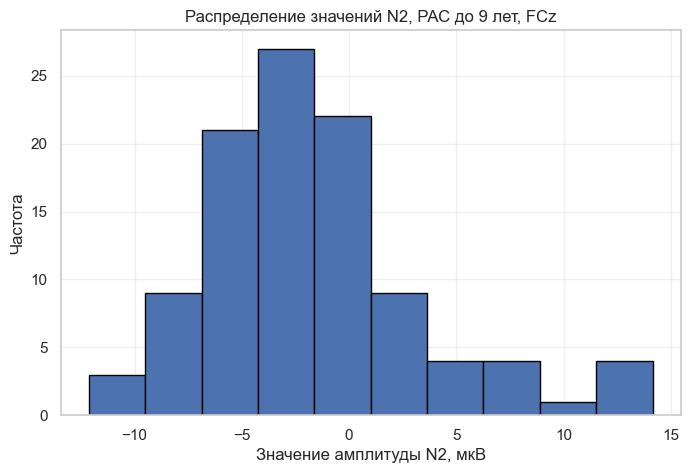

In [61]:
#Распредление значений амплитуд N2 компоненты. ГИСТОГРАММА
plt.figure(figsize = (8, 5))
plt.hist(df_td_ASD_under_9['N2_AMP'], bins=10, edgecolor='black')
plt.title('Распределение значений N2, РАС до 9 лет, '+chan)
plt.xlabel('Значение амплитуды N2, мкВ')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
# Сохранение при необходимости
plt.savefig('.\\Images\\N2_comp\\N2_histogram.png', dpi=300, bbox_inches='tight')

plt.show()

Аутлаер - ['A077_intensityn.EDF']
Аутлаер - ['A083_intensityn.EDF']
Аутлаер - ['A083_intensityn.EDF']
Аутлаер - ['A083_intensityn.EDF']
Аутлаер - ['A083_intensityn.EDF']


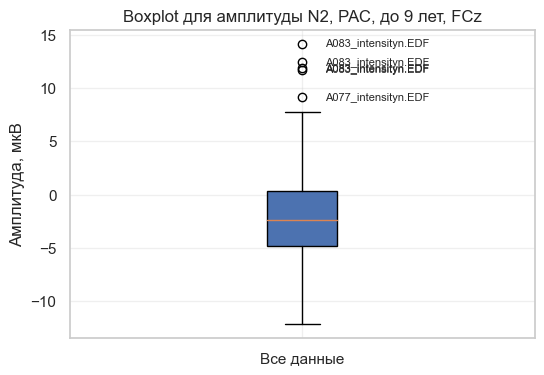

In [60]:
#Распредление значений амплитуд N2 компоненты. БОКСПЛОТ
plt.figure(figsize=(6, 4))
box = plt.boxplot(df_td_ASD_under_9['N2_AMP'], vert=True, patch_artist=True, labels= ['Все данные'])

plt.title('Boxplot для амплитуды N2, РАС, до 9 лет, '+chan)
plt.ylabel('Амплитуда, мкВ')
plt.grid(True, alpha=0.3)

# Определение аутлаеров
fliers = box['fliers'][0].get_ydata()  # значения аутлаеров
outliers = df_td_ASD_under_9[df_td_ASD_under_9['N2_AMP'].isin(fliers)]

# Подписываем аутлаеры на графике
for y in fliers:
    label = df_td_ASD_under_9.loc[df_td_ASD_under_9['N2_AMP'] == y, 'ID'].values
    if len(label) > 0:
        plt.text(1.05, y, label[0], va='center', fontsize=8)
    print(f'Аутлаер - {label}')

# Сохранение при необходимости
plt.savefig('.\\Images\\N2_comp\\N2_boxplot.png', dpi=300, bbox_inches='tight')

plt.show()

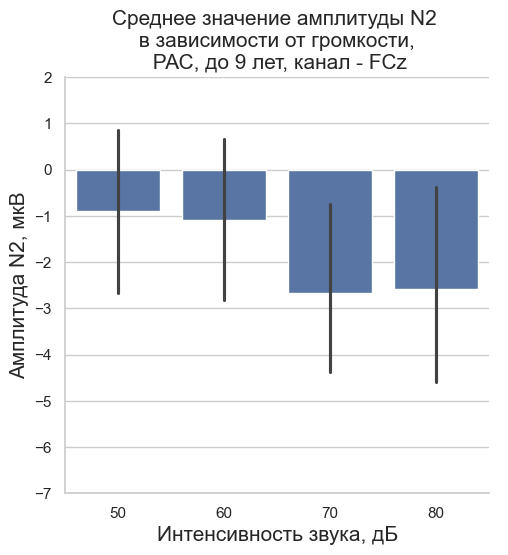

In [67]:
# Визуализация средней амплитуды по условиям + доверительный интервал
# Установка неинтерактивной среды (inline/qt)
%matplotlib inline
sns.set(style="whitegrid", font_scale=1)
g=sns.catplot(x='COND', y='N2_AMP', data=df_td_ASD_under_9, kind= 'bar')

plt.title('Среднее значение амплитуды N2 \n в зависимости от громкости, \n РАС, до 9 лет, канал - '+chan, size=15)
plt.xticks(ticks=[0, 1, 2, 3], labels=['50', '60', '70', '80'])

plt.xlabel('Интенсивность звука, дБ', fontsize=15)
plt.ylabel('Амплитуда N2, мкВ', fontsize=15)
g.set(ylim=(-7, 2))

plt.savefig('.\\Images\\N2_comp\\N2_between_int.png', dpi=300, bbox_inches='tight')

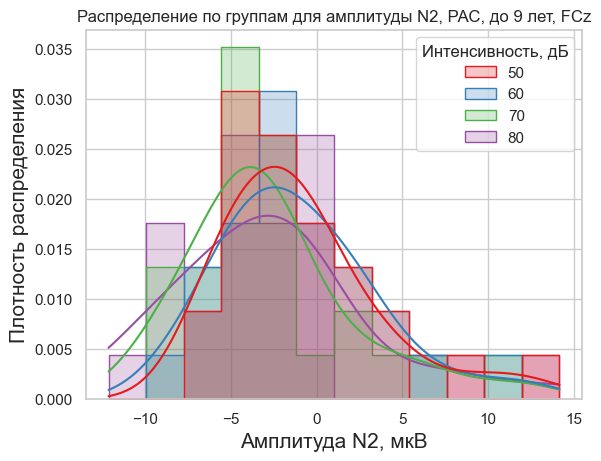

In [89]:
#Визуализация распределения по условиям. ГИСТОГРАММА
ax = sns.histplot(data=df_td_ASD_under_9, x='N2_AMP', hue='COND', kde=True, element='step', stat='density',
            palette=sns.color_palette("Set1"))
plt.title("Распределение по группам для амплитуды N2, РАС, до 9 лет, "+chan)
plt.xlabel('Амплитуда N2, мкВ', fontsize=15)
plt.ylabel('Плотность распределения', fontsize=15)
legend = ax.get_legend()
legend.set_title('Интенсивность, дБ')
plt.savefig('.\\Images\\N2_comp\\N2_between_int_hist.png', dpi=300, bbox_inches='tight')

plt.show()

In [118]:
# Функция - визуализация распредление по условиям + аутлаеры. БОКСПЛОТ
%matplotlib inline
def plot_n2_outliers_by_group(df, group_col, value_col):
    g = df[['ID', group_col, value_col]].copy()
    g[value_col] = pd.to_numeric(g[value_col], errors='coerce')
    g = g.dropna(subset=[value_col])

    cats = list(pd.unique(g[group_col]))
    pos = np.arange(1, len(cats) + 1)

    fig, ax = plt.subplots(figsize=(max(5, 1.6*len(cats)), 4))

    rng = np.random.default_rng(1)
    outlier_rows = []

    # подготовим данные и нарисуем boxplot
    data = [g.loc[g[group_col] == c, value_col].values for c in cats]
    ax.boxplot(data, positions=pos, widths=0.6, patch_artist=True,
               showfliers=False, medianprops=dict(linewidth=2))

    # точки + подписи у аутлаеров (IQR по КАЖДОЙ группе)
    for i, c in enumerate(cats, start=1):
        sub = g[g[group_col] == c].copy()
        q1, q3 = sub[value_col].quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        sub['is_outlier'] = (sub[value_col] < low) | (sub[value_col] > high)

        # все точки группы
        x_all = np.full(len(sub), i, dtype=float) + rng.normal(0, 0.06, size=len(sub))
        ax.scatter(x_all, sub[value_col].values, s=22, alpha=0.9, edgecolor='k', linewidth=0.3, zorder=3)

        # подписи для аутлаеров
        sub_ol = sub[sub['is_outlier']]
        x_ol = np.full(len(sub_ol), i, dtype=float) + rng.normal(0, 0.06, size=len(sub_ol))
        for (x, y, id_) in zip(x_ol, sub_ol[value_col], sub_ol['ID']):
            ax.annotate(str(id_), xy=(x, y), xytext=(3, 0), textcoords='offset points',
                        fontsize=8, ha='left', va='center')
        outlier_rows.append(sub_ol[['ID', group_col, value_col]])

    ax.set_xticks(pos); ax.set_xticklabels(cats, rotation=0)
    ax.set_xlabel(group_col); ax.set_ylabel(value_col)
    ax.set_title(f'Амплитуда {value_col} по условиям ({group_col}): подписи ID у аутлаеров (Tukey IQR)')
    ax.margins(y=0.1)
    plt.tight_layout(); plt.show()

    outliers_by_group_p = pd.concat(outlier_rows, axis=0).sort_values([group_col, value_col])

    return fig, outliers_by_group_p

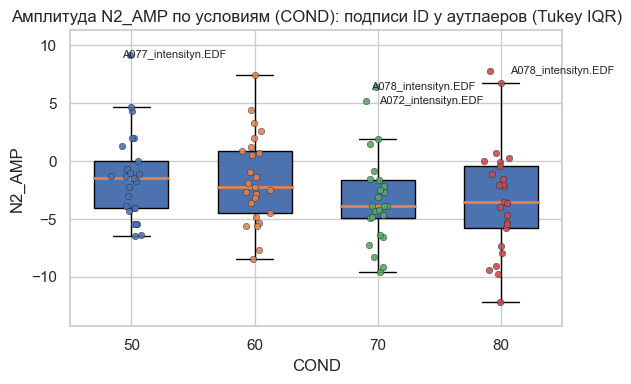

In [119]:
# визуализация распредление по условиям + аутлаеры. БОКСПЛОТ
fig, outliers_by_cond_ASD = plot_n2_outliers_by_group(
    df_td_ASD_under_9,
    group_col='COND',
    value_col='N2_AMP'
)

fig.savefig(r'.\Images\N2_comp\N2_between_int_boxplot.png',
            dpi=300, bbox_inches='tight')

In [87]:
#Проверка нормального распределения данных внутри условия
for g in df_td_ASD_under_9['COND'].unique():
    stat, p = shapiro(df_td_ASD_under_9[df_td_ASD_under_9['COND'] == g]['N2_AMP'])
    print(f"Группа {g}: p = {p:.4f} {'(нормально)' if p > 0.05 else '(не нормально)'}")

Группа 50: p = 0.0079 (не нормально)
Группа 60: p = 0.2436 (нормально)
Группа 70: p = 0.0183 (не нормально)
Группа 80: p = 0.0724 (нормально)


In [91]:
#Удаление выбросов
df_td_ASD_under_9 = df_td_ASD_under_9[df_td_ASD_under_9['ID'] != 'A083_intensityn.EDF']
eeg_files_ASD.remove('A083_intensityn.EDF')

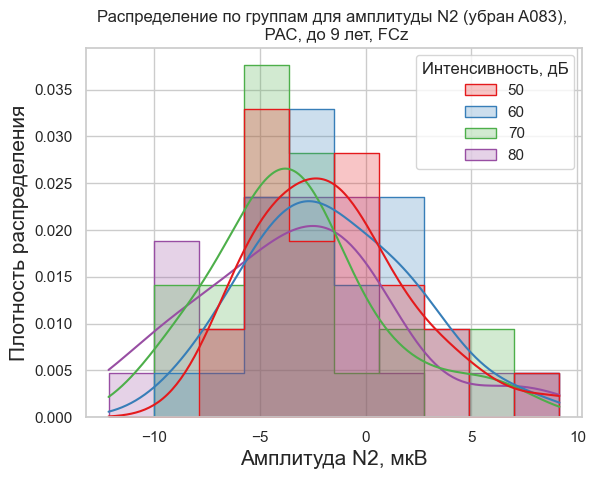

In [92]:
#Визуализация распределения по условиям. ГИСТОГРАММА
ax = sns.histplot(data=df_td_ASD_under_9, x='N2_AMP', hue='COND', kde=True, element='step', stat='density',
            palette=sns.color_palette("Set1"))
plt.title("Распределение по группам для амплитуды N2 (убран A083), \n РАС, до 9 лет, "+chan)
plt.xlabel('Амплитуда N2, мкВ', fontsize=15)
plt.ylabel('Плотность распределения', fontsize=15)
legend = ax.get_legend()
legend.set_title('Интенсивность, дБ')
plt.savefig('.\\Images\\N2_comp\\N2_between_int_hist_out_83.png', dpi=300, bbox_inches='tight')

plt.show()

In [93]:
#Проверка нормального распределения данных внутри условия
for g in df_td_ASD_under_9['COND'].unique():
    stat, p = shapiro(df_td_ASD_under_9[df_td_ASD_under_9['COND'] == g]['N2_AMP'])
    print(f"Группа {g}: p = {p:.4f} {'(нормально)' if p > 0.05 else '(не нормально)'}")

Группа 50: p = 0.0774 (нормально)
Группа 60: p = 0.9441 (нормально)
Группа 70: p = 0.1964 (нормально)
Группа 80: p = 0.4865 (нормально)


Был убран выброс в виде A083, без него выравнивалась нормальность подгрупп 50 и 70 дБ

In [94]:
# Сохранение таблицы ID-амплитуда N2 c удаленными выбросами
df_td_ASD_under_9.to_excel(
    'YOUR_PATH')

ValueError: No engine for filetype: ''

## Расчет медианных локальных регрессий (ME)

In [ ]:
import statsmodels.api as sm

In [95]:
'''Оценка индивидуального градиента (slope) зависимости амплитуды N2 от интенсивности стимула:
для каждого испытуемого строятся линейные модели по всем парам уровней громкости,
затем берётся медиана slope-ов как сводная характеристика'''
# Список уровней интенсивности стимула (в дБ)
conditions = [50, 60, 70, 80]
# Все возможные пары уровней интенсивности
pairs = [x for x in itertools.combinations(conditions, 2)]
# Словарь, куда для каждого испытуемого будем складывать углы наклона (slope)
# зависимости амплитуды N2 от интенсивности по разным парам уровней
me_n2 = {}
# Цикл по всем испытуемым (ID файлов ЭЭГ)
for sub in eeg_files_ASD:
    me_n2[sub] = []
    # Выбираем строки только этого испытуемого из общего датафрейма
    df_sub = df_td_ASD_under_9[df_td_ASD_under_9['ID'] == sub]
    # Цикл по всем парам уровней интенсивности
    for pair in pairs:
        # Оставляем в данных только две рассматриваемые интенсивности
        df_pair = df_sub[df_sub['COND'].isin(pair)]
        # Предиктор: интенсивность (COND), добавляем константу для свободного члена в модели
        X = sm.add_constant(df_pair['COND'])
         # Зависимая переменная: амплитуда N2
        y = df_pair['N2_AMP']
        # Линейная регрессия: N2 ~ const + COND, внутри пары уровней
        model = sm.OLS(y, X).fit()
        # slope - угол наклона, то есть коэффициент при интенсивности
        slope = model.params['COND']
        # Добавляем slope в список для данного испытуемого
        me_n2[sub].append(slope)
        
# Для каждого испытуемого считаем медиану по всем рассчитанным slope  
medians_N2_ASD = [np.median(me_n2[x]) for x in me_n2]

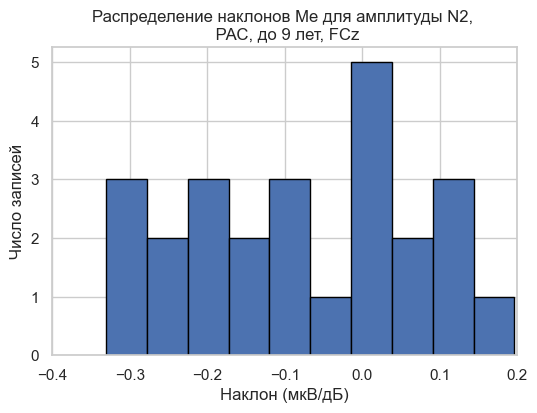

In [100]:
# Распределение значений накловнов Me для амплитуд N2
plt.figure(figsize=(6, 4))
plt.hist(medians_N2_ASD, bins= 10, edgecolor='black')
plt.title('Распределение наклонов Me для амплитуды N2, \n РАС, до 9 лет, ' + chan)
plt.xlabel('Наклон (мкВ/дБ)')
plt.ylabel('Число записей')
plt.xlim(-0.4, 0.2)
plt.savefig('.\\Images\\N2_comp\\N2_Me_hist.png', dpi=300, bbox_inches='tight')

plt.show()

In [112]:
# Считаем для каждого испытуемого медиану его значений ME_N2 (игнорируя NaN)
med_ser = pd.Series({sub: np.nanmedian(vals) for sub, vals in me_n2.items()})
# Превращаем Series в DataFrame:
med_df = med_ser.rename('median_ME_N2').reset_index().rename(columns={'index':'ID'})

# Удаление NaN
med_df = med_df.dropna(subset=['median_ME_N2'])
med_df

,ID,median_ME_N2
0,A001_intensityn.EDF,-0.226805
1,A002_intensityn.EDF,-0.220630
2,A004_intensityn.EDF,-0.009426
3,A005_intensityn.EDF,-0.284763
4,A009_intensityn.EDF,-0.277388
5,A014_intensityn.EDF,0.196363
6,A015_intensityn.EDF,-0.008211
7,A023_intensityn.EDF,-0.203635
8,A024_intensityn.EDF,0.038301
9,A026_intensityn.EDF,-0.281596


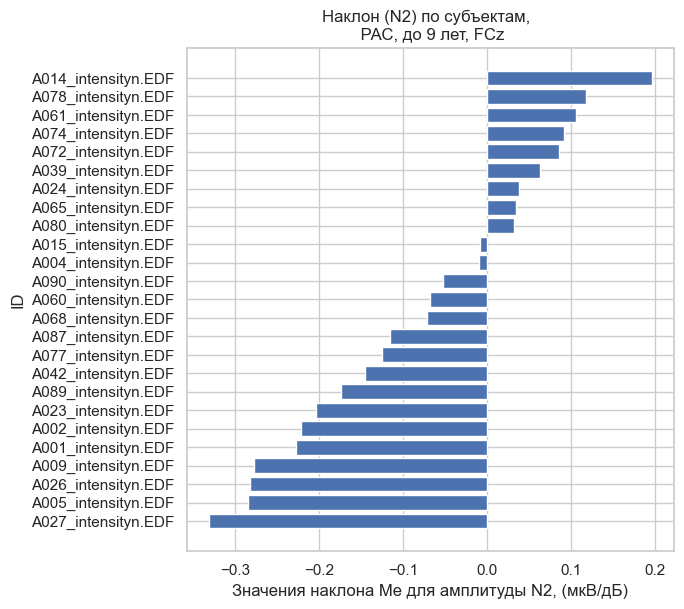

In [108]:
# Визуализация распределения значений медианного ME(N2) по испытуемым
# Сортировка испытуемых от меньшего значения наклона к большему
df_plot = med_df.sort_values('median_ME_N2')
# Построение графика 
fig, ax = plt.subplots(figsize=(7, max(3, 0.25*len(df_plot))))
ax.barh(df_plot['ID'].astype(str), df_plot['median_ME_N2'])
ax.set_xlabel('Значения наклона Me для амплитуды N2, (мкВ/дБ)')
ax.set_ylabel('ID')
ax.set_title('Наклон (N2) по субъектам,  \n РАС, до 9 лет, ' + chan)
plt.tight_layout()
plt.savefig('.\\Images\\N2_comp\\N2_Me_bars.png', dpi=300, bbox_inches='tight')

plt.show()

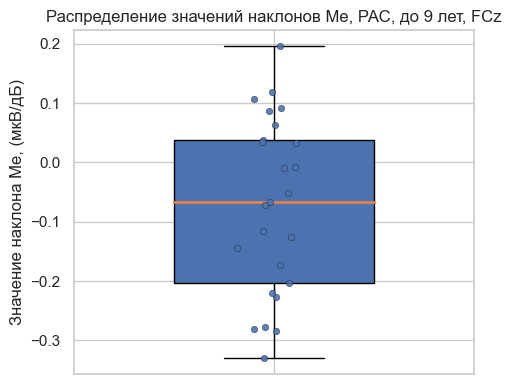

In [111]:
#  Визуализация распределения значений медианного ME(N2). БОКСПЛОТ
x = med_df['median_ME_N2'].values

fig, ax = plt.subplots(figsize=(5,4))
ax.boxplot([x], positions=[1], widths=0.5, patch_artist=True, showfliers=False,
           medianprops=dict(linewidth=2))

# точки с лёгким джиттером
rng = np.random.default_rng(0)
jitter = rng.normal(0, 0.04, size=len(x))
ax.scatter(np.ones_like(x)+jitter, x, s=22, alpha=0.9, edgecolor='k', linewidth=0.3, zorder=3)

# линия среднего
ax.hlines(np.nanmean(x), 0.8, 1.2, linestyles='dashed')

ax.set_xticks([1]); ax.set_xticklabels([''])
ax.set_ylabel('Значение наклона Me, (мкВ/дБ)')
ax.set_title('Распределение значений наклонов Me, РАС, до 9 лет, ' + chan)
plt.tight_layout()
plt.savefig('.\\Images\\N2_comp\\N2_Me_boxplot.png', dpi=300, bbox_inches='tight')

plt.show()

# Сохранение таблицы с полученными значениями

In [114]:
# Создание таблицы (при необходимости можно добавить дополнительные параметры)
slopes_Me_ASD_under_9 =pd.DataFrame({
                                    'ID':eeg_files,
                                    'Me N2':medians_N2_ASD, 
})

slopes_Me_ASD_under_9

,ID,Me N2
0,A001_intensityn.EDF,-0.226805
1,A002_intensityn.EDF,-0.220630
2,A004_intensityn.EDF,-0.009426
3,A005_intensityn.EDF,-0.284763
4,A009_intensityn.EDF,-0.277388
5,A014_intensityn.EDF,0.196363
6,A015_intensityn.EDF,-0.008211
7,A023_intensityn.EDF,-0.203635
8,A024_intensityn.EDF,0.038301
9,A026_intensityn.EDF,-0.281596


In [39]:
# Сохранение таблицы
slopes_ASF_ASD_under_9.to_excel(r"YOURPATH\file.xlsx", index=False)
slopes_ASF_ASD_under_9.to_csv(r"YOURPATH\file.csv", index=False)